# **Curso IA desde Cero**

* Dr. Irvin Hussein López Nava
* M.C. Joan M. Raygoza Romero

# Preparar el conjunto de datos

## Librerias

In [126]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer

## Cargar el conjunto de datos

In [127]:
df = pd.read_csv('emoevent_es.csv', sep="\t", encoding='utf-8')
print(df.shape)
df.head()

(8409, 4)


,id,tweet,emotion,offensive
0,1,Acabo de ver la gran pérdida que estamos tenie...,sadness,0
1,2,USER ¿A que vamos a reconstruir Notre Dame ant...,sadness,0
2,3,Desde ayer andan sufriendo por el incendio de ...,anger,0
3,4,Muy afectada -como muchísima gente- por lo ocu...,sadness,0
4,5,Es una mierda lo que paso en HASHTAG pero plea...,disgust,1


## Histograma de emociones

<Axes: >

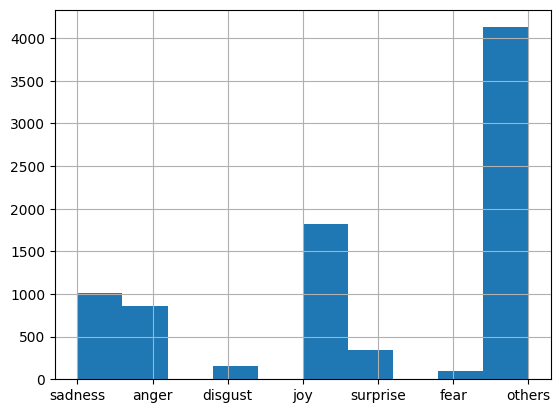

In [128]:
df['emotion'].hist()

## Filtrar las emociones para quedarnos con las de interés (feliz, neutral, enojado, triste)

In [129]:
df = df[df["emotion"].isin(["joy", "others", "anger", "sadness"])]
df = df.replace("joy", "happy")
df = df.replace("others", "neutral")
df = df.replace("anger", "angry")
df = df.replace("sadness", "sad")

<Axes: >

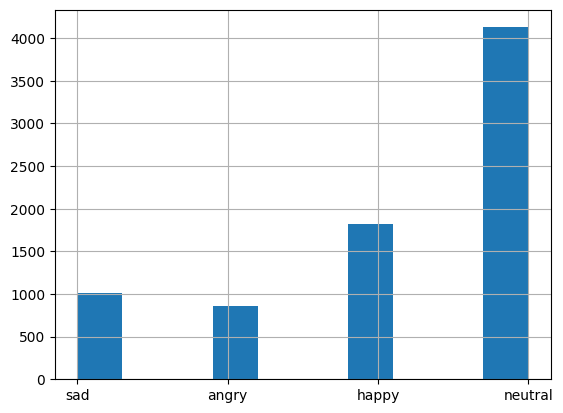

In [130]:
df['emotion'].hist()

## Extraer embeddings utilizando un transformer

In [131]:
emb_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
embs = emb_model.encode(df['tweet'].values)

## Crear nuestro conjunto de datos

In [132]:
embeddings_df = pd.DataFrame(embs)
embeddings_df['emotion'] = df['emotion'].values
print(embeddings_df.shape)
embeddings_df.head()
embeddings_df.to_csv('embeddings.csv', index=False)

(7808, 385)


# Haciendo nuestro modelo

## Librerias

In [134]:
from sklearn.model_selection import KFold,StratifiedKFold,GroupKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression


import matplotlib.pyplot as plt
import pickle
import seaborn as sns

## Leer el conjunto de datos

In [133]:
df = pd.read_csv('embeddings.csv')

## Preparar datos de entrada y salida

In [135]:
x = df.drop(['emotion'], axis=1).to_numpy()
le = LabelEncoder()
y = le.fit_transform(df['emotion'])

## Entrenamiento con validación cruzada

Fold 0: 0.5979876876984738
Fold 1: 0.6082897099756808
Fold 2: 0.48857714622209225
Fold 3: 0.663073661516885
Fold 4: 0.6674903455441556
Mean F1 score macro: 0.6144811794313739
              precision    recall  f1-score   support

           0       0.57      0.40      0.47       857
           1       0.65      0.48      0.55      1815
           2       0.68      0.83      0.75      4127
           3       0.76      0.63      0.69      1009

    accuracy                           0.68      7808
   macro avg       0.67      0.58      0.61      7808
weighted avg       0.67      0.68      0.67      7808



Text(50.722222222222214, 0.5, 'True')

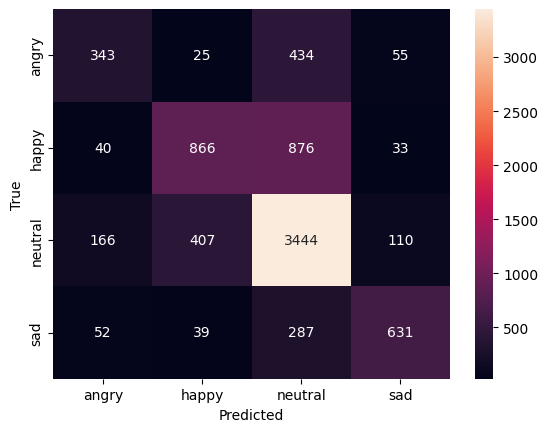

In [142]:
kf = StratifiedKFold(n_splits=5)
scores = []
conf_matrix = []
preds = []
true = []

for i, (train_index, test_index) in enumerate(kf.split(x,y)):
    x_train = x[train_index]
    x_test = x[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    model = SVC(kernel='rbf', probability=True).fit(x_train, y_train)
    y_pred = model.predict(x_test)

    preds += list(y_pred)
    true += list(y_test)

    scores.append(f1_score(y_test, y_pred, average='macro'))
    matrix = confusion_matrix(y_test, y_pred)
    conf_matrix.append(matrix)
    #print(classification_report(y_test, y_pred))
    print(f"Fold {i}: {scores[-1]}")
print(f"Mean F1 score macro: {f1_score(true, preds, average='macro')}")
print(classification_report(true, preds))
sns.heatmap(np.sum(conf_matrix, axis=0), annot=True, fmt='g', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')

## Entrenar el modelo con todo el conjunto de datos y guardarlo junto con el label encoder

In [143]:
model = SVC(kernel='rbf', probability=True).fit(x, y)

pickle.dump(model, open('model_text.pkl', 'wb'))
pickle.dump(le, open('le_text.pkl', 'wb'))

# Probar el modelo

## Instalar SpeechRecognition y pydub

In [79]:
!pip install SpeechRecognition pydub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 16.0 MB/s eta 0:00:00


## Función para grabar audio en colab

In [138]:
from google.colab import output
from base64 import b64decode
import io
from pydub import AudioSegment
import speech_recognition as sr

def grabar_audio():
    # JavaScript para grabar audio desde el navegador
    js = """
    const sleep = time => new Promise(resolve => setTimeout(resolve, time));
    const b64ToUint8Array = b64 => Uint8Array.from(atob(b64), c => c.charCodeAt(0));

    var record = true;

    async function recordAudio() {
      const stream = await navigator.mediaDevices.getUserMedia({ audio: true });
      const mediaRecorder = new MediaRecorder(stream);
      let chunks = [];

      mediaRecorder.ondataavailable = e => chunks.push(e.data);
      mediaRecorder.start();

      // Botón para detener grabación
      const rec_btn = document.createElement('button');
      rec_btn.innerHTML = "⏺️ Detener grabación";
      rec_btn.style.fontSize = "20px";
      rec_btn.style.marginTop = "10px";
      document.body.appendChild(rec_btn);

      await new Promise(resolve => rec_btn.onclick = resolve);

      mediaRecorder.stop();
      await new Promise(resolve => mediaRecorder.onstop = resolve);

      const blob = new Blob(chunks);
      stream.getTracks().forEach(track => track.stop());
      const reader = new FileReader();
      reader.readAsDataURL(blob);

      return await new Promise(resolve => {
        reader.onloadend = () => resolve(reader.result.split(',')[1]);
      });
    }

    recordAudio();
    """

    # Ejecutar JS y obtener audio en base64
    audio_b64 = output.eval_js(js)

    # Convertir base64 a WAV en Python
    audio_bytes = b64decode(audio_b64)
    audio = AudioSegment.from_file(io.BytesIO(audio_bytes), format="webm")
    audio = audio.set_frame_rate(16000).set_channels(1)

    wav_io = io.BytesIO()
    audio.export(wav_io, format="wav")
    wav_io.seek(0)
    return wav_io

## Función para transcribir el audio

In [139]:
def transcribir_audio(wav_io):
    r = sr.Recognizer()

    with sr.AudioFile(wav_io) as source:
        audio = r.record(source)

    try:
        texto = r.recognize_google(audio, language="es-MX")
        print("✔️ Transcripción:")
        print(texto)
        return texto
    except Exception as e:
        print("❌ Error al transcribir:", str(e))


## Grabar audio, obtener el texto y usar el modelo

In [141]:
wav = grabar_audio()
text = transcribir_audio(wav)
embedding = emb_model.encode(text)
print("La emocion es:", le.inverse_transform(model.predict(embedding.reshape(1, -1)))[0])

✔️ Transcripción:
es que tú no sabes lo que sentí O sea la verdad es que me sentí decepcionado
La emocion es: sad
